### First, run the following 8 cells:

In [1]:
# Use findspark module indicating the directory in which spark was installed
import findspark
findspark.init('/home/jaime/spark-2.4.0-bin-hadoop2.7')

In [2]:
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc

In [3]:
# Can only run this once. restart your kernel for any errors.
sc = SparkContext()

In [4]:
ssc = StreamingContext(sc, 10)
sqlContext = SQLContext(sc)

In [5]:
socket_stream = ssc.socketTextStream("127.0.0.1", 9998)

In [6]:
lines = socket_stream.window(20)

In [7]:
# tuple where each element is assigned a name (fields: tag & count)
from collections import namedtuple
fields = ("tag", "count")
Tweet = namedtuple('Tweet', fields)

In [8]:
# Use Parenthesis for multiple lines or use \.
( lines.flatMap(lambda text: text.split(" ")) #Splits to a list
  .filter(lambda word: word.lower().startswith("#")) # Checks for hashtag calls
  .map(lambda word: (word.lower(), 1)) # Lower cases the word
  .reduceByKey(lambda a, b: a + b) # Reduces
  .map(lambda rec: Tweet(rec[0], rec[1])) # Stores in a Tweet Object
  .foreachRDD(lambda rdd: rdd.toDF().sort(desc("count")) # Sorts Them in a DF
  .limit(10).registerTempTable("tweets")) ) # Registers to a table.

__________
### Now run *twitterScanner.py*
__________

### Then, run the following 3 cells:


In [9]:
ssc.start()

In [10]:
# Imports needed to plot stuff
import time
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
# Only works for Jupyter Notebooks!
%matplotlib inline

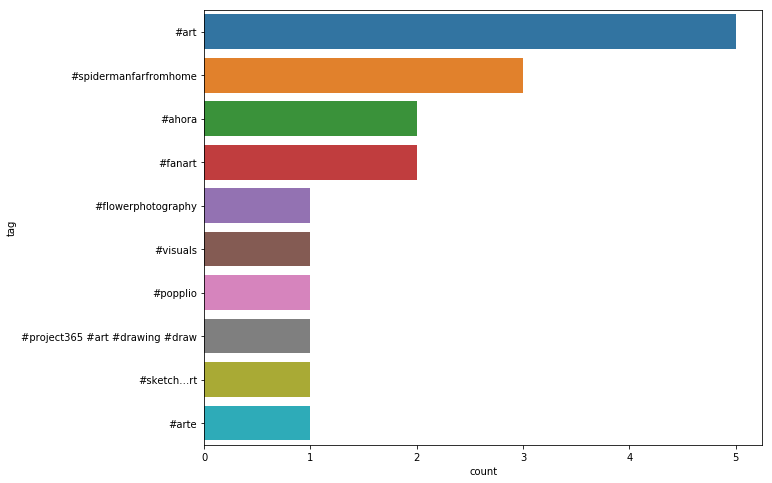

In [11]:
count = 0

while count < 10:
    time.sleep(2)  # wait 2 seconds until 'refreshing'
    top_10_tweets = sqlContext.sql('Select tag, count from tweets')
    # Turn the 10 tweets into a pandas dataframe
    top_10_df = top_10_tweets.toPandas()
    display.clear_output(wait=True)  # For refreshing the plots
    plt.figure(figsize=(10,8))
    sns.barplot( x="count", y="tag", data=top_10_df)
    plt.show()
    count = count + 1

__________
### To stop, run:


In [12]:
ssc.stop()